In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from shapely import geometry
from functools import partial

import pyproj
from shapely import geometry
from shapely.geometry import Point, shape
from shapely.ops import transform

print('Libraries imported.')

Libraries imported.


Imported dataframe containing districts in Halifax, Nova Scotia, Canada and their latitudes and longitudes.
Source is wikipedia.com

In [2]:
df = pd.read_excel("halifax.xlsx")
dff = df.copy()
df

Areas   Latitude  Longitude
0     Downtown Halifax  44.648444 -63.573278
1       The Hydrostone  44.661722 -63.599389
2    North End Halifax  44.663139 -63.601278
3    West End, Halifax  44.650008 -63.621289
4    Quinpool district  44.645922 -63.594892
5             Richmond  44.666583 -63.598528
6    South End Halifax  44.634972 -63.583028
7        Spring Garden  44.642611 -63.578444
8              Armdale  44.636389 -63.631389
9          Boulderwood  44.623056 -63.600000
10        Clayton Park  44.656944 -63.650556
11          Cowie Hill  44.621389 -63.621389
12            Fairview  44.654722 -63.638056
13           Fairmount  44.645889 -63.628278
14       Melville Cove  44.631667 -63.627778
15          Rockingham  44.670556 -63.641667
16           Spryfield  44.604083 -63.608611
17     Crystal Heights  44.687217 -63.582275
18      Highfield Park  44.687411 -63.588647
19          Brightwood  44.675200 -63.572100
20            Burnside  44.692500 -63.600278
21       Crichton Park  44.681111 -63.567528
22  Downtown Dartmouth  44.665786 -63.566514
23           Imperoyal  44.641389 -63.534444
24          Manor Park  44.670508 -63.544367
25           Nantucket  44.672686 -63.517878
26    Portland Estates  44.665000 -63.515000
27      Portland Hills  44.664111 -63.510386
28        Port Wallace  44.698056 -63.547222
29        Shannon Park  44.680556 -63.604167
30         Tuft's Cove  44.676556 -63.596333
31     Wallace Heights  44.686389 -63.606111
32            Westphal  44.685000 -63.546944
33            Woodlawn  44.683056 -63.533056
34            Woodside  44.645000 -63.542222
35             Bedford  44.732120 -63.656760
36         Beaver Bank  44.801944 -63.688056
37          Birch Cove  44.683889 -63.673056
38          Fall River  44.826319 -63.608056
39           Glen Moir  44.722778 -63.678056
40     Hammonds Plains  44.733889 -63.775556
41     Lower Sackville  44.776389 -63.695556
42    Middle Sackville  44.795583 -63.730111
43       Princes Lodge  44.696389 -63.660556
44     Upper Sackville  44.805556 -63.750278
45            Waverley  44.772778 -63.578056
46          Wellington  44.865000 -63.616389
47    Windsor Junction  44.789167 -63.642222

Districts plotted on Halifax Map:

In [3]:
# create map of halifax using latitude and longitude values
map_halifax = folium.Map(location=[44.648444, -63.573278], zoom_start=10)
neighborhoods = df
# add markers to map
for lat, lng, areas in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Areas']):
    label = '{}'.format(areas)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_halifax)  
    
map_halifax

Read in Crime Data in Halifax:

In [4]:
crime = pd.read_csv("Crime.csv")
print(crime.shape)
crime.head()

(73, 10)


X          Y  OBJECTID evt_rt  evt_rin             evt_date  \
0 -63.590656  44.654974      4069     GO  1114780  2021/01/05 03:59:59   
1 -63.590656  44.654974      4070     GO  1114646  2021/01/05 03:59:59   
2 -63.544882  44.671300      4071     GO  1114678  2021/01/05 03:59:59   
3 -63.588192  44.679849      4072     GO  1115051  2021/01/06 03:59:59   
4 -63.584664  44.680037      4073     GO  1115084  2021/01/06 03:59:59   

       location zone  rucr       rucr_ext_d  
0    MAYNARD ST   C4  1430          ASSAULT  
1    MAYNARD ST   C4  1430          ASSAULT  
2     MARCS WAY   E3  1420          ASSAULT  
3  CATHERINE ST   E5  2120  BREAK AND ENTER  
4   VICTORIA RD   E5  2120  BREAK AND ENTER

(1)Read Json file with community boundaries of Halifax Area (2)Function to check if coordinate in crime df is in one of the community areas and if yes then adds the community name in GSA_NAME column

In [5]:
with open('Community_Boundaries.geojson') as f:
    js = json.load(f)
    

# check each polygon to see if it contains the point
def add_GSA_NAME(coordinates):
    coordinates = coordinates.split(",")
    point = Point(float(coordinates[0]), float(coordinates[1]))
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature["properties"]['GSA_NAME']
        
crime['coordinates'] = crime['X'].map(str).str.cat(crime['Y'].map(str),sep=",")
crime['GSA_NAME'] = crime['coordinates'].apply(add_GSA_NAME)
crime

X          Y  OBJECTID evt_rt  evt_rin             evt_date  \
0  -63.590656  44.654974      4069     GO  1114780  2021/01/05 03:59:59   
1  -63.590656  44.654974      4070     GO  1114646  2021/01/05 03:59:59   
2  -63.544882  44.671300      4071     GO  1114678  2021/01/05 03:59:59   
3  -63.588192  44.679849      4072     GO  1115051  2021/01/06 03:59:59   
4  -63.584664  44.680037      4073     GO  1115084  2021/01/06 03:59:59   
5  -63.525937  44.656018      4074     GO  1115003  2021/01/05 03:59:59   
6  -63.482465  44.672504      4075     GO  1114776  2021/01/05 03:59:59   
7  -63.600789  44.645666      4076     GO  1115027  2021/01/06 03:59:59   
8  -63.581636  44.650914      4077     GO  1114949  2021/01/05 03:59:59   
9  -63.615064  44.666330      4078     GO  1115059  2021/01/06 03:59:59   
10 -63.589616  44.673777      4079     GO  1115048  2021/01/06 03:59:59   
11 -63.658568  44.659264      4080     GO  1114991  2021/01/06 03:59:59   
12 -63.629880  44.660666      4081     GO  1115079  2021/01/06 03:59:59   
13 -63.631223  44.656897      4082     GO  1115077  2021/01/06 03:59:59   
14 -63.615785  44.663267      4083     GO  1115114  2021/01/06 03:59:59   
15 -63.599552  44.651376      4084     GO  1115156  2021/01/06 03:59:59   
16 -63.590375  44.675165      4085     GO  1115147  2021/01/06 03:59:59   
17 -63.537759  44.682272      4086     GO  1114635  2021/01/05 03:59:59   
18 -63.633735  44.657911      4087     GO  1114898  2021/01/05 03:59:59   
19 -63.584997  44.656010      4088     GO  1115098  2021/01/06 03:59:59   
20 -63.540618  44.516444      4089     GO  1115135  2021/01/06 03:59:59   
21 -63.599552  44.651376      4090     GO  1115085  2021/01/06 03:59:59   
22 -63.603278  44.657948      4091     GO  1115119  2021/01/06 03:59:59   
23 -63.597275  44.645445      4092     GO  1115380  2021/01/07 03:59:59   
24 -63.680186  44.782259      4093     GO  1114629  2021/01/05 03:59:59   
25 -63.588192  44.679849      4094     GO  1115496  2021/01/07 03:59:59   
26 -63.943005  44.659697      4095     GO  1115278  2021/01/07 03:59:59   
27 -63.613058  44.859013      4096     GO  1115142  2021/01/06 03:59:59   
28 -63.612140  44.670705      4097     GO  1115303  2021/01/07 03:59:59   
29 -63.596261  44.651657      4098     GO  1115423  2021/01/07 03:59:59   
30 -63.553758  44.674028      4099     GO  1115224  2021/01/07 03:59:59   
31 -63.614934  44.665263      4100     GO  1115384  2021/01/07 03:59:59   
32 -63.548754  44.659599      4101     GO  1115416  2021/01/07 03:59:59   
33 -63.583653  44.686396      4102     GO  1115374  2021/01/07 03:59:59   
34 -63.543640  44.682167      4103     GO  1115318  2021/01/07 03:59:59   
35 -63.551709  44.663816      4104     GO  1115457  2021/01/07 03:59:59   
36 -63.495584  44.685515      4105     GO  1115235  2021/01/07 03:59:59   
37 -63.461444  44.616620      4106     GO  1115066  2021/01/06 03:59:59   
38 -63.585587  44.679727      4107     GO  1114972  2021/01/06 03:59:59   
39 -63.575763  44.638672      4108     GO  1115365  2021/01/07 03:59:59   
40 -63.580495  44.650082      4109     GO  1115562  2021/01/08 03:59:59   
41 -63.613589  44.667409      4110     GO  1115458  2021/01/08 03:59:59   
42 -63.615858  44.606466      4111     GO  1115601  2021/01/08 03:59:59   
43 -63.589224  44.645230      4112     GO  1115282  2021/01/07 03:59:59   
44 -63.697175  44.778883      4113     GO  1115593  2021/01/08 03:59:59   
45 -63.570993  44.641289      4114     GO  1115579  2021/01/08 03:59:59   
46 -63.695152  44.768325      4115     GO  1115569  2021/01/08 03:59:59   
47 -63.538995  44.682008      4116     GO  1115403  2021/01/08 03:59:59   
48 -63.567387  44.671266      4117     GO  1115572  2021/01/08 03:59:59   
49 -63.633735  44.657911      4118     GO  1115603  2021/01/08 03:59:59   
50 -63.621170  44.627755      4119     GO  1115578  2021/01/08 03:59:59   
51 -63.584345  44.673202      4120     GO  1115600  2021/01/08 03:59:59   
52 -63.575028  44.641566      4121   

Function to check if coordinate in crime is in within 5000 m radius of the Areas in df. If yes then checks which of the Areas is closest to it and adds that Areas name to the Areas column in crime:

In [6]:
def add_area(coordinates):
    # create your two points
    coordinates = coordinates.split(",")
    
    lon, lat = float(coordinates[0]), float(coordinates[1])
    radius = 5000  # in m

    local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(
        lat, lon
    )
    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
        pyproj.Proj(local_azimuthal_projection),
    )
    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
    )

    center = Point(float(lon), float(lat))
    point_transformed = transform(wgs84_to_aeqd, center)
    buffer = point_transformed.buffer(radius)
    # Get the polygon with lat lon coordinates
    circle_poly = transform(aeqd_to_wgs84, buffer)
    
    # create your circle buffer from one of the points
    min = 1000000
    areas = np.nan
    for row in df.itertuples():
        point_1 = geometry.Point(row[3], row[2])
        # and you can then check if the other point lies within
        if point_1.within(circle_poly):
            d = Point(float(coordinates[0]), float(coordinates[1])).distance(point_1)
            if d < min:
                areas = row[1]
                min = d
    return areas

crime['Areas'] = crime['coordinates'].apply(add_area)
crime

X          Y  OBJECTID evt_rt  evt_rin             evt_date  \
0  -63.590656  44.654974      4069     GO  1114780  2021/01/05 03:59:59   
1  -63.590656  44.654974      4070     GO  1114646  2021/01/05 03:59:59   
2  -63.544882  44.671300      4071     GO  1114678  2021/01/05 03:59:59   
3  -63.588192  44.679849      4072     GO  1115051  2021/01/06 03:59:59   
4  -63.584664  44.680037      4073     GO  1115084  2021/01/06 03:59:59   
5  -63.525937  44.656018      4074     GO  1115003  2021/01/05 03:59:59   
6  -63.482465  44.672504      4075     GO  1114776  2021/01/05 03:59:59   
7  -63.600789  44.645666      4076     GO  1115027  2021/01/06 03:59:59   
8  -63.581636  44.650914      4077     GO  1114949  2021/01/05 03:59:59   
9  -63.615064  44.666330      4078     GO  1115059  2021/01/06 03:59:59   
10 -63.589616  44.673777      4079     GO  1115048  2021/01/06 03:59:59   
11 -63.658568  44.659264      4080     GO  1114991  2021/01/06 03:59:59   
12 -63.629880  44.660666      4081     GO  1115079  2021/01/06 03:59:59   
13 -63.631223  44.656897      4082     GO  1115077  2021/01/06 03:59:59   
14 -63.615785  44.663267      4083     GO  1115114  2021/01/06 03:59:59   
15 -63.599552  44.651376      4084     GO  1115156  2021/01/06 03:59:59   
16 -63.590375  44.675165      4085     GO  1115147  2021/01/06 03:59:59   
17 -63.537759  44.682272      4086     GO  1114635  2021/01/05 03:59:59   
18 -63.633735  44.657911      4087     GO  1114898  2021/01/05 03:59:59   
19 -63.584997  44.656010      4088     GO  1115098  2021/01/06 03:59:59   
20 -63.540618  44.516444      4089     GO  1115135  2021/01/06 03:59:59   
21 -63.599552  44.651376      4090     GO  1115085  2021/01/06 03:59:59   
22 -63.603278  44.657948      4091     GO  1115119  2021/01/06 03:59:59   
23 -63.597275  44.645445      4092     GO  1115380  2021/01/07 03:59:59   
24 -63.680186  44.782259      4093     GO  1114629  2021/01/05 03:59:59   
25 -63.588192  44.679849      4094     GO  1115496  2021/01/07 03:59:59   
26 -63.943005  44.659697      4095     GO  1115278  2021/01/07 03:59:59   
27 -63.613058  44.859013      4096     GO  1115142  2021/01/06 03:59:59   
28 -63.612140  44.670705      4097     GO  1115303  2021/01/07 03:59:59   
29 -63.596261  44.651657      4098     GO  1115423  2021/01/07 03:59:59   
30 -63.553758  44.674028      4099     GO  1115224  2021/01/07 03:59:59   
31 -63.614934  44.665263      4100     GO  1115384  2021/01/07 03:59:59   
32 -63.548754  44.659599      4101     GO  1115416  2021/01/07 03:59:59   
33 -63.583653  44.686396      4102     GO  1115374  2021/01/07 03:59:59   
34 -63.543640  44.682167      4103     GO  1115318  2021/01/07 03:59:59   
35 -63.551709  44.663816      4104     GO  1115457  2021/01/07 03:59:59   
36 -63.495584  44.685515      4105     GO  1115235  2021/01/07 03:59:59   
37 -63.461444  44.616620      4106     GO  1115066  2021/01/06 03:59:59   
38 -63.585587  44.679727      4107     GO  1114972  2021/01/06 03:59:59   
39 -63.575763  44.638672      4108     GO  1115365  2021/01/07 03:59:59   
40 -63.580495  44.650082      4109     GO  1115562  2021/01/08 03:59:59   
41 -63.613589  44.667409      4110     GO  1115458  2021/01/08 03:59:59   
42 -63.615858  44.606466      4111     GO  1115601  2021/01/08 03:59:59   
43 -63.589224  44.645230      4112     GO  1115282  2021/01/07 03:59:59   
44 -63.697175  44.778883      4113     GO  1115593  2021/01/08 03:59:59   
45 -63.570993  44.641289      4114     GO  1115579  2021/01/08 03:59:59   
46 -63.695152  44.768325      4115     GO  1115569  2021/01/08 03:59:59   
47 -63.538995  44.682008      4116     GO  1115403  2021/01/08 03:59:59   
48 -63.567387  44.671266      4117     GO  1115572  2021/01/08 03:59:59   
49 -63.633735  44.657911      4118     GO  1115603  2021/01/08 03:59:59   
50 -63.621170  44.627755      4119     GO  1115578  2021/01/08 03:59:59   
51 -63.584345  44.673202      4120     GO  1115600  2021/01/08 03:59:59   
52 -63.575028  44.641566      4121   

In [7]:
# all rows in crime dataframe with nan in Areas column dropped
crime1 = crime.copy()
crime.dropna(subset=['Areas'], inplace=True)

Function that adds to the crime count columns in df for each crime in crime that falls within 2000 metres of Areas in df: 

In [8]:
def add_crime_count(coordinates):
    
    # create your two points
    coordinates = coordinates.split(",")
    
    lon, lat = float(coordinates[1]), float(coordinates[0])
    radius = 2000  # in m

    local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(
        lat, lon
    )
    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
        pyproj.Proj(local_azimuthal_projection),
    )
    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
    )

    center = Point(float(lon), float(lat))
    point_transformed = transform(wgs84_to_aeqd, center)
    buffer = point_transformed.buffer(radius)
    # Get the polygon with lat lon coordinates
    circle_poly = transform(aeqd_to_wgs84, buffer)
    count = 0
    # create your circle buffer from one of the points
    
    for row in crime.itertuples():
        point_1 = geometry.Point(row[1], row[2])
        # and you can then check if the other point lies within
        if point_1.within(circle_poly):
            count +=1
    return count

df['coordinates'] = df['Latitude'].map(str).str.cat(df['Longitude'].map(str),sep=",")
df['crime_count'] = df['coordinates'].apply(add_crime_count)
df

Areas   Latitude  Longitude           coordinates  \
0     Downtown Halifax  44.648444 -63.573278  44.648444,-63.573278   
1       The Hydrostone  44.661722 -63.599389  44.661722,-63.599389   
2    North End Halifax  44.663139 -63.601278  44.663139,-63.601278   
3    West End, Halifax  44.650008 -63.621289  44.650008,-63.621289   
4    Quinpool district  44.645922 -63.594892  44.645922,-63.594892   
5             Richmond  44.666583 -63.598528  44.666583,-63.598528   
6    South End Halifax  44.634972 -63.583028  44.634972,-63.583028   
7        Spring Garden  44.642611 -63.578444  44.642611,-63.578444   
8              Armdale  44.636389 -63.631389  44.636389,-63.631389   
9          Boulderwood  44.623056 -63.600000       44.623056,-63.6   
10        Clayton Park  44.656944 -63.650556  44.656944,-63.650556   
11          Cowie Hill  44.621389 -63.621389  44.621389,-63.621389   
12            Fairview  44.654722 -63.638056  44.654722,-63.638056   
13           Fairmount  44.645889 -63.628278  44.645889,-63.628278   
14       Melville Cove  44.631667 -63.627778  44.631667,-63.627778   
15          Rockingham  44.670556 -63.641667  44.670556,-63.641667   
16           Spryfield  44.604083 -63.608611  44.604083,-63.608611   
17     Crystal Heights  44.687217 -63.582275  44.687217,-63.582275   
18      Highfield Park  44.687411 -63.588647  44.687411,-63.588647   
19          Brightwood  44.675200 -63.572100      44.6752,-63.5721   
20            Burnside  44.692500 -63.600278    44.6925,-63.600278   
21       Crichton Park  44.681111 -63.567528  44.681111,-63.567528   
22  Downtown Dartmouth  44.665786 -63.566514  44.665786,-63.566514   
23           Imperoyal  44.641389 -63.534444  44.641389,-63.534444   
24          Manor Park  44.670508 -63.544367  44.670508,-63.544367   
25           Nantucket  44.672686 -63.517878  44.672686,-63.517878   
26    Portland Estates  44.665000 -63.515000        44.665,-63.515   
27      Portland Hills  44.664111 -63.510386  44.664111,-63.510386   
28        Port Wallace  44.698056 -63.547222  44.698056,-63.547222   
29        Shannon Park  44.680556 -63.604167  44.680556,-63.604167   
30         Tuft's Cove  44.676556 -63.596333  44.676556,-63.596333   
31     Wallace Heights  44.686389 -63.606111  44.686389,-63.606111   
32            Westphal  44.685000 -63.546944     44.685,-63.546944   
33            Woodlawn  44.683056 -63.533056  44.683056,-63.533056   
34            Woodside  44.645000 -63.542222     44.645,-63.542222   
35             Bedford  44.732120 -63.656760    44.73212,-63.65676   
36         Beaver Bank  44.801944 -63.688056  44.801944,-63.688056   
37          Birch Cove  44.683889 -63.673056  44.683889,-63.673056   
38          Fall River  44.826319 -63.608056  44.826319,-63.608056   
39           Glen Moir  44.722778 -63.678056  44.722778,-63.678056   
40     Hammonds Plains  44.733889 -63.775556  44.733889,-63.775556   
41     Lower Sackville  44.776389 -63.695556  44.776389,-63.695556   
42    Middle Sackville  44.795583 -63.730111  44.795583,-63.730111   
43       Princes Lodge  44.696389 -63.660556  44.696389,-63.660556   
44     Upper Sackville  44.805556 -63.750278  44.805556,-63.750278   
45            Waverley  44.772778 -63.578056  44.772778,-63.578056   
46          Wellington  44.865000 -63.616389     44.865,-63.616389   
47    Windsor Junction  44.789167 -63.642222  44.789167,-63.642222   

    crime_count  
0            16  
1            25  
2            23  
3            16  
4            19  
5            26  
6            10  
7            19  
8             4  
9             2  
10            8  
11            3  
12            8  
13            7  
14            2  
15            6  
16            1  
17           12  
18           12  
19           16  
20            7  
21           16  
22           10  
23            1  
24            9  
25            3  
26            1  
27            1  
28            4  
29           15  
30           15  
31        

Get nearby venues for each district in Halifax using a radius of 500 meters:

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


Saved data returned from foursquare in halifax_venues.csv before which I read in now:

In [10]:
'''halifax_venues = getNearbyVenues(names=df['Areas'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )'''
halifax_venues = pd.read_csv("halifax_venues.csv")

In [11]:
print(halifax_venues.shape)
halifax_venues.head()

(458, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Downtown Halifax              44.648444              -63.573278   
1  Downtown Halifax              44.648444              -63.573278   
2  Downtown Halifax              44.648444              -63.573278   
3  Downtown Halifax              44.648444              -63.573278   
4  Downtown Halifax              44.648444              -63.573278   

                                       Venue  Venue Latitude  Venue Longitude  \
0                         Stillwell Beer Bar       44.646908       -63.573875   
1  GoodLife Fitness Halifax Barrington Place       44.649803       -63.574935   
2            The Old Triangle Irish Alehouse       44.647654       -63.572307   
3            Maritime Museum of the Atlantic       44.647499       -63.571040   
4                         Strange Adventures       44.647742       -63.571615   

  Venue Category  
0            Bar  
1            Gym  
2            Pub  
3         Museum  
4      Bookstore

One hot encoding to return halifax_onehot with Venue Category and Neighborhoods:

In [12]:
# one hot encoding
halifax_onehot = pd.get_dummies(halifax_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
halifax_onehot['Neighborhood'] = halifax_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [halifax_onehot.columns[-1]] + list(halifax_onehot.columns[:-1])
halifax_onehot = halifax_onehot[fixed_columns]

halifax_onehot.head()

Neighborhood  American Restaurant  Antique Shop  Art Gallery  \
0  Downtown Halifax                    0             0            0   
1  Downtown Halifax                    0             0            0   
2  Downtown Halifax                    0             0            0   
3  Downtown Halifax                    0             0            0   
4  Downtown Halifax                    0             0            0   

   Arts & Crafts Store  Asian Restaurant  Auto Dealership  Bakery  Bank  Bar  \
0                    0                 0                0       0     0    1   
1                    0                 0                0       0     0    0   
2                    0                 0                0       0     0    0   
3                    0                 0                0       0     0    0   
4                    0                 0                0       0     0    0   

   Baseball Field  Beach  Big Box Store  Bookstore  Breakfast Spot  Brewery  \
0               0      0              0          0               0        0   
1               0      0              0          0               0        0   
2               0      0              0          0               0        0   
3               0      0              0          0               0        0   
4               0      0              0          1               0        0   

   Burger Joint  Burrito Place  Bus Station  Business Service  Café  \
0             0              0            0                 0     0   
1             0              0            0                 0     0   
2             0              0            0                 0     0   
3             0              0            0                 0     0   
4             0              0            0                 0     0   

   Candy Store  Caribbean Restaurant  Chinese Restaurant  Clothing Store  \
0            0                     0                   0               0   
1            0                     0                   0               0   
2            0                     0                   0               0   
3            0                     0                   0               0   
4            0                     0                   0               0   

   Cocktail Bar  Coffee Shop  College Cafeteria  Comfort Food Restaurant  \
0             0            0                  0                        0   
1             0            0                  0                        0   
2             0            0                  0                        0   
3             0            0                  0                        0   
4             0            0                  0                        0   

   Construction & Landscaping  Convenience Store  Cosmetics Shop  Creperie  \
0                           0                  0               0         0   
1                           0                  0               0         0   
2                           0                  0               0         0   
3                           0                  0               0         0   
4                           0                  0               0         0   

   Department Store  Dessert Shop  Diner  Discount Store  Dive Bar  Dog Run  \
0                 0             0      0               0         0        0   
1                 0             0      0               0         0        0   
2                 0             0      0               0         0        0   
3                 0             0      0               0         0        0   
4                 0             0      0               0         0        0   

   Dry Cleaner  Dumpling Restaurant  Electronics Store  Event Service  \
0            0                    0                  0              0   
1            0                    0                  0              0   
2            0                    0                  0              0   
3            0                    0            

One hot encoding to return crime_onehot with Crime type and Neighborhoods:

In [13]:
# one hot encoding
crime_onehot = pd.get_dummies(crime[['rucr_ext_d']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
crime_onehot['Neighborhood'] = crime['Areas'] 

# move neighborhood column to the first column
fixed_columns = [crime_onehot.columns[-1]] + list(crime_onehot.columns[:-1])
crime_onehot = crime_onehot[fixed_columns]

crime_onehot.head()

Neighborhood  ASSAULT  BREAK AND ENTER  THEFT FROM VEHICLE  \
0  Quinpool district        1                0                   0   
1  Quinpool district        1                0                   0   
2         Manor Park        1                0                   0   
3     Highfield Park        0                1                   0   
4    Crystal Heights        0                1                   0   

   THEFT OF VEHICLE  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

Create halifax_grouped with mean of each category related to Neighborhood. This table will be used for kmeans clustering:

In [14]:
halifax_grouped = halifax_onehot.groupby('Neighborhood').mean().reset_index()
crime_grouped = crime_onehot.groupby('Neighborhood').mean().reset_index()

halifax_grouped.set_index('Neighborhood', inplace=True)
crime_grouped.set_index('Neighborhood', inplace=True)
halifax_grouped = pd.concat([crime_grouped, halifax_grouped], axis=1)
halifax_grouped.reset_index(inplace=True)

# remove Wellington Neighborhood row and replaced nans with 0s as no crimes reported there
halifax_grouped.rename(columns={"index":"Neighborhood"}, inplace=True)
halifax_grouped = halifax_grouped[halifax_grouped["Neighborhood"] != "Wellington"]
halifax_grouped.fillna(0, inplace=True)

halifax_grouped

Neighborhood   ASSAULT  BREAK AND ENTER  THEFT FROM VEHICLE  \
0           Brightwood  1.000000         0.000000            0.000000   
1         Clayton Park  0.500000         0.500000            0.000000   
2           Cowie Hill  0.500000         0.000000            0.000000   
3        Crichton Park  0.000000         0.000000            1.000000   
4      Crystal Heights  0.333333         0.333333            0.333333   
5   Downtown Dartmouth  0.000000         1.000000            0.000000   
6     Downtown Halifax  1.000000         0.000000            0.000000   
7            Fairmount  0.500000         0.000000            0.500000   
8             Fairview  0.000000         1.000000            0.000000   
9            Glen Moir  1.000000         0.000000            0.000000   
10      Highfield Park  0.000000         0.750000            0.000000   
11           Imperoyal  1.000000         0.000000            0.000000   
12     Lower Sackville  0.666667         0.000000            0.333333   
13          Manor Park  0.400000         0.000000            0.600000   
14           Nantucket  0.000000         1.000000            0.000000   
15   North End Halifax  1.000000         0.000000            0.000000   
16    Portland Estates  0.000000         0.000000            1.000000   
17      Portland Hills  1.000000         0.000000            0.000000   
18   Quinpool district  0.545455         0.272727            0.181818   
19        Shannon Park  1.000000         0.000000            0.000000   
20       Spring Garden  0.333333         0.333333            0.333333   
21           Spryfield  1.000000         0.000000            0.000000   
22      The Hydrostone  0.000000         1.000000            0.000000   
23         Tuft's Cove  0.333333         0.666667            0.000000   
25   West End, Halifax  0.000000         0.500000            0.500000   
26            Westphal  0.500000         0.000000            0.000000   
27            Woodlawn  0.500000         0.500000            0.000000   
28             Armdale  0.000000         0.000000            0.000000   
29         Beaver Bank  0.000000         0.000000            0.000000   
30             Bedford  0.000000         0.000000            0.000000   
31          Birch Cove  0.000000         0.000000            0.000000   
32         Boulderwood  0.000000         0.000000            0.000000   
33            Burnside  0.000000         0.000000            0.000000   
34          Fall River  0.000000         0.000000            0.000000   
35     Hammonds Plains  0.000000         0.000000            0.000000   
36       Melville Cove  0.000000         0.000000            0.000000   
37    Middle Sackville  0.000000         0.000000            0.000000   
38        Port Wallace  0.000000         0.000000            0.000000   
39       Princes Lodge  0.000000         0.000000            0.000000   
40            Richmond  0.000000         0.000000            0.000000   
41          Rockingham  0.000000         0.000000            0.000000   
42   South End Halifax  0.000000         0.000000            0.000000   
43     Upper Sackville  0.000000         0.000000            0.000000   
44     Wallace Heights  0.000000         0.000000            0.000000   
45            Waverley  0.000000         0.000000            0.000000   
46    Windsor Junction  0.000000         0.000000            0.000000   
47            Woodside  0.000000         0.000000            0.000000   

    THEFT OF VEHICLE  American Restaurant  Antique Shop  Art Gallery  \
0               0.00             0.000000           0.0         0.00   
1               0.00             0.000000           0.0         0.00   
2               0.50             0.000000           0.0         0.00   
3               0.00             0.000000           0.0         0.00   
4               0.00             0.000000           0.0         0.00   
5               0.00             0.000000           0.0         0.00   
6

In [15]:
halifax_grouped.shape

(47, 146)

Functions to create most common venues and crimes dataframes:

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[6:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def return_most_common_crimes(row, num_top_venues):
    row_categories = row.iloc[1:5]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = halifax_grouped['Neighborhood']

for ind in np.arange(halifax_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(halifax_grouped.iloc[ind, :], num_top_venues)
    
neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Brightwood           Golf Course           Pizza Place   
1     Clayton Park             Rest Area   Housing Development   
2       Cowie Hill           Gas Station              Pharmacy   
3    Crichton Park      Business Service        Baseball Field   
4  Crystal Heights          Hockey Arena                   Bar   

  3rd Most Common Venue    4th Most Common Venue 5th Most Common Venue  \
0                  Farm        Food & Drink Shop          Fishing Spot   
1                  Park              Yoga Studio                  Farm   
2            Restaurant  State / Provincial Park           Yoga Studio   
3           Dry Cleaner      Dumpling Restaurant     Electronics Store   
4                Office              Coffee Shop           Pizza Place   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0           Fish Market     Fish & Chips Shop  Fast Food Restaurant   
1          Fishing Spot           Fish Market     Fish & Chips Shop   
2          Fishing Spot           Fish Market     Fish & Chips Shop   
3         Event Service           Event Space                  Farm   
4                 Hotel                   Gym     Food & Drink Shop   

  9th Most Common Venue 10th Most Common Venue  
0        Farmers Market            Yoga Studio  
1  Fast Food Restaurant         Farmers Market  
2  Fast Food Restaurant         Farmers Market  
3        Farmers Market    Fried Chicken Joint  
4           Dry Cleaner    Dumpling Restaurant

In [18]:
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Crime'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Crime'.format(ind+1))

# create a new dataframe
neighborhoods_crimes_sorted = pd.DataFrame(columns=columns)
neighborhoods_crimes_sorted['Neighborhood'] = halifax_grouped['Neighborhood']

for ind in np.arange(halifax_grouped.shape[0]):
    neighborhoods_crimes_sorted.iloc[ind, 1:] = return_most_common_crimes(halifax_grouped.iloc[ind, :], num_top_venues)
    
neighborhoods_crimes_sorted.head()

Neighborhood 1st Most Common Crime 2nd Most Common Crime  \
0       Brightwood               ASSAULT      THEFT OF VEHICLE   
1     Clayton Park       BREAK AND ENTER               ASSAULT   
2       Cowie Hill      THEFT OF VEHICLE               ASSAULT   
3    Crichton Park    THEFT FROM VEHICLE      THEFT OF VEHICLE   
4  Crystal Heights    THEFT FROM VEHICLE       BREAK AND ENTER   

  3rd Most Common Crime 4th Most Common Crime  
0    THEFT FROM VEHICLE       BREAK AND ENTER  
1      THEFT OF VEHICLE    THEFT FROM VEHICLE  
2    THEFT FROM VEHICLE       BREAK AND ENTER  
3       BREAK AND ENTER               ASSAULT  
4               ASSAULT      THEFT OF VEHICLE

Find the best value to use for k for kmeans clustering using the elbow method:

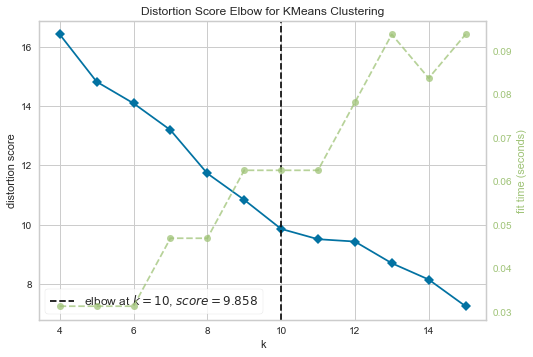

In [19]:
from yellowbrick.cluster import KElbowVisualizer

X = halifax_grouped.drop('Neighborhood', 1)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,16))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Best k was found to be 10 and this is used in the kmeans clustering algorithm:

In [20]:
# set number of clusters
kclusters = 10

halifax_grouped_clustering = halifax_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(halifax_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 8, 9, 3, 8, 4, 1, 5, 4, 1])

In [21]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

halifax_merged = dff.copy()

# merge halifax_grouped with halifax_data to add latitude/longitude for each neighborhood
halifax_merged = halifax_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Areas')

halifax_merged.head()

Areas   Latitude  Longitude  Cluster Labels  \
0   Downtown Halifax  44.648444 -63.573278             1.0   
1     The Hydrostone  44.661722 -63.599389             4.0   
2  North End Halifax  44.663139 -63.601278             1.0   
3  West End, Halifax  44.650008 -63.621289             8.0   
4  Quinpool district  44.645922 -63.594892             8.0   

       1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                 Restaurant                 Hotel            Steakhouse   
1                Coffee Shop           Pizza Place                  Park   
2  Middle Eastern Restaurant                  Café      Sushi Restaurant   
3                Coffee Shop        Clothing Store  Fast Food Restaurant   
4                       Café  Fast Food Restaurant           Pizza Place   

  4th Most Common Venue 5th Most Common Venue  6th Most Common Venue  \
0           Coffee Shop      Sushi Restaurant          Shopping Mall   
1        Sandwich Place      Asian Restaurant                   Pool   
2           Pizza Place                  Pool                    Pub   
3            Restaurant              Pharmacy         Cosmetics Shop   
4     Convenience Store      Greek Restaurant  Outdoors & Recreation   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                Bakery                   Pub             Gastropub   
1        Discount Store  Fast Food Restaurant    Chinese Restaurant   
2        Sandwich Place    Seafood Restaurant           Coffee Shop   
3        Lingerie Store           Pizza Place            Shoe Store   
4            Shoe Store    Seafood Restaurant           Coffee Shop   

  10th Most Common Venue  
0          Historic Site  
1   Caribbean Restaurant  
2   Fast Food Restaurant  
3    Sporting Goods Shop  
4               Pharmacy

In [22]:
# same for the crimes part of data
neighborhoods_crimes_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
crime_merged = dff.copy()
crime_merged = crime_merged.join(neighborhoods_crimes_sorted.set_index('Neighborhood'), on='Areas')

crime_merged.head()

Areas   Latitude  Longitude  Cluster Labels  \
0   Downtown Halifax  44.648444 -63.573278             1.0   
1     The Hydrostone  44.661722 -63.599389             4.0   
2  North End Halifax  44.663139 -63.601278             1.0   
3  West End, Halifax  44.650008 -63.621289             8.0   
4  Quinpool district  44.645922 -63.594892             8.0   

  1st Most Common Crime 2nd Most Common Crime 3rd Most Common Crime  \
0               ASSAULT      THEFT OF VEHICLE    THEFT FROM VEHICLE   
1       BREAK AND ENTER      THEFT OF VEHICLE    THEFT FROM VEHICLE   
2               ASSAULT      THEFT OF VEHICLE    THEFT FROM VEHICLE   
3    THEFT FROM VEHICLE       BREAK AND ENTER      THEFT OF VEHICLE   
4               ASSAULT       BREAK AND ENTER    THEFT FROM VEHICLE   

  4th Most Common Crime  
0       BREAK AND ENTER  
1               ASSAULT  
2       BREAK AND ENTER  
3               ASSAULT  
4      THEFT OF VEHICLE

In [23]:
# cast cluster labels to integer type
halifax_merged.dropna(inplace=True)
halifax_merged['Cluster Labels'] = halifax_merged['Cluster Labels'].astype(int)

crime_merged.dropna(inplace=True)
crime_merged['Cluster Labels'] = crime_merged['Cluster Labels'].astype(int)

Map of the 10 clusters in Halifax:

In [24]:
# create map
map_clusters = folium.Map(location=[44.648444, -63.573278], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(halifax_merged['Latitude'], halifax_merged['Longitude'], halifax_merged['Areas'], halifax_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Show the number of crimes (count) in each community (GSA_NAME):

In [25]:
df2 = crime1.groupby(["GSA_NAME"]).count()
df2 = pd.DataFrame(df2["rucr_ext_d"])
df2.reset_index(inplace = True)
df2.columns = ["GSA_NAME", "Count"]
df2

GSA_NAME  Count
0           BEDFORD      1
1  BOUTILIERS POINT      1
2      COLE HARBOUR      2
3         DARTMOUTH     23
4   EASTERN PASSAGE      3
5           HALIFAX     37
6   LOWER SACKVILLE      3
7    PLEASANT POINT      1
8   PORTUGUESE COVE      1
9        WELLINGTON      1

Map showing the 10 clusters in the Halifax Area and a superimposed choropleth map with the communities with the reported crime count:

In [27]:
folium.Choropleth(
    geo_data=js,
    data=df2,
    columns=['GSA_NAME', 'Count'],
    key_on='feature.properties.GSA_NAME',
    fill_color='YlOrRd', 
    fill_opacity=0.5, 
    line_opacity=0.2,
    nan_fill_color="white",
    nan_fill_opacity=0.4,
    legend_name='Crime Count'
).add_to(map_clusters)

# display map
map_clusters

Cluster 1:

In [28]:
cluster1 = halifax_merged.loc[halifax_merged['Cluster Labels'] == 0, halifax_merged.columns[[0] + list(range(4, halifax_merged.shape[1]))]]
print(cluster1.shape)
cluster1

(19, 11)


Areas       1st Most Common Venue       2nd Most Common Venue  \
5            Richmond                        Pool                      Bakery   
6   South End Halifax                 Coffee Shop                        Café   
8             Armdale                 Pizza Place           Convenience Store   
9         Boulderwood                       Beach           Electronics Store   
14      Melville Cove            Business Service           Food & Drink Shop   
15         Rockingham                  Food Court                         Gym   
20           Burnside  Construction & Landscaping                  Hobby Shop   
28       Port Wallace                  Steakhouse              Sandwich Place   
31    Wallace Heights                Hockey Arena         Sporting Goods Shop   
34           Woodside                 Coffee Shop                 Pizza Place   
35            Bedford               Grocery Store                         Pub   
36        Beaver Bank                 Pizza Place           Convenience Store   
37         Birch Cove                       Hotel                 Pizza Place   
38         Fall River              Sandwich Place                 Yoga Studio   
40    Hammonds Plains               Garden Center  Construction & Landscaping   
42   Middle Sackville                 Pizza Place                Soccer Field   
43      Princes Lodge                       Hotel                 Fish Market   
44    Upper Sackville                         Pub  Construction & Landscaping   
47   Windsor Junction           Other Repair Shop      Furniture / Home Store   

         3rd Most Common Venue       4th Most Common Venue  \
5                 Gourmet Shop                        Park   
6            College Cafeteria                     Dog Run   
8   Construction & Landscaping                 Yoga Studio   
9                      Theater                 Yoga Studio   
14                Soccer Field                 Coffee Shop   
15                   Bookstore                 Yoga Studio   
20      Furniture / Home Store             Auto Dealership   
28                 Coffee Shop                 Karaoke Bar   
31                  Hobby Shop             Harbor / Marina   
34                    Pharmacy                 Dry Cleaner   
35                        Bank              Sandwich Place   
36                 Yoga Studio              Farmers Market   
37           Convenience Store               Shopping Mall   
38                        Farm           Food & Drink Shop   
40                        Farm                 Yoga Studio   
42                      Bakery              Hunting Supply   
43           Convenience Store                 Yoga Studio   
44                        Farm           Food & Drink Shop   
47                   Pet Store  Construction & Landscaping   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
5   Caribbean Restaurant           Hockey Rink   Dumpling Restaurant   
6             Food Truck            Food Court     Food & Drink Shop   
8         Farmers Market     Food & Drink Shop          Fishing Spot   
9             Food Court     Food & Drink Shop          Fishing Spot   
14              Dive Bar            Food Court          Fishing Spot   
15  Fast Food Restaurant     Food & Drink Shop          Fishing Spot   
20        Shop & Service                  Farm          Fishing Spot   
28        Farmers Market     Food & Drink Shop          Fishing Spot   
31     Food & Drink Shop              Dive Bar               Dog Run   
34  Fast Food Restaurant          Burger Joint            Restaurant   
35           Coffee Shop         Shopping Mall        Breakfast Spot   
36     Food & Drink Shop          Fishing Spot           Fish Market   
37          Liquor Store           Coffee Shop        Sandwich Place   
38          Fishing Spot           Fish Market     Fish & Chips Shop   
40  Fast Food Restaurant            Food Court     Food & Drink Shop   
42

In [29]:
cluster1.describe()

Areas 1st Most Common Venue 2nd Most Common Venue  \
count             19                    19                    19   
unique            19                    15                    16   
top     Port Wallace           Pizza Place           Pizza Place   
freq               1                     3                     2   

       3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
count                     19                    19                    19   
unique                    16                    14                    13   
top                     Farm           Yoga Studio  Fast Food Restaurant   
freq                       3                     5                     3   

       6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
count                     19                    19                    19   
unique                    11                     9                     8   
top               Food Court          Fishing Spot           Fish Market   
freq                       4                     6                     6   

       9th Most Common Venue 10th Most Common Venue  
count                     19                     19  
unique                     9                      9  
top        Fish & Chips Shop   Fast Food Restaurant  
freq                       7                      6

In [30]:
cluster1 = crime_merged.loc[crime_merged['Cluster Labels'] == 0, crime_merged.columns[[0] + list(range(1, crime_merged.shape[1]))]]
print(cluster1.shape)
cluster1

(19, 8)


Areas   Latitude  Longitude  Cluster Labels  \
5            Richmond  44.666583 -63.598528               0   
6   South End Halifax  44.634972 -63.583028               0   
8             Armdale  44.636389 -63.631389               0   
9         Boulderwood  44.623056 -63.600000               0   
14      Melville Cove  44.631667 -63.627778               0   
15         Rockingham  44.670556 -63.641667               0   
20           Burnside  44.692500 -63.600278               0   
28       Port Wallace  44.698056 -63.547222               0   
31    Wallace Heights  44.686389 -63.606111               0   
34           Woodside  44.645000 -63.542222               0   
35            Bedford  44.732120 -63.656760               0   
36        Beaver Bank  44.801944 -63.688056               0   
37         Birch Cove  44.683889 -63.673056               0   
38         Fall River  44.826319 -63.608056               0   
40    Hammonds Plains  44.733889 -63.775556               0   
42   Middle Sackville  44.795583 -63.730111               0   
43      Princes Lodge  44.696389 -63.660556               0   
44    Upper Sackville  44.805556 -63.750278               0   
47   Windsor Junction  44.789167 -63.642222               0   

   1st Most Common Crime 2nd Most Common Crime 3rd Most Common Crime  \
5       THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
6       THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
8       THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
9       THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
14      THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
15      THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
20      THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
28      THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
31      THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
34      THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
35      THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
36      THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
37      THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
38      THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
40      THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
42      THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
43      THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
44      THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   
47      THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER   

   4th Most Common Crime  
5                ASSAULT  
6                ASSAULT  
8                ASSAULT  
9                ASSAULT  
14               ASSAULT  
15               ASSAULT  
20               ASSAULT  
28               ASSAULT  
31               ASSAULT  
34               ASSAULT  
35               ASSAULT  
36               ASSAULT  
37               ASSAULT  
38               ASSAULT  
40               ASSAULT  
42               ASSAULT  
43               ASSAULT  
44               ASSAULT  
47               ASSAULT

Cluster 2:

In [31]:
cluster2 = halifax_merged.loc[halifax_merged['Cluster Labels'] == 1, halifax_merged.columns[[0] + list(range(4, halifax_merged.shape[1]))]]
print(cluster2.shape)
cluster2

(7, 11)


Areas      1st Most Common Venue 2nd Most Common Venue  \
0    Downtown Halifax                 Restaurant                 Hotel   
2   North End Halifax  Middle Eastern Restaurant                  Café   
16          Spryfield               Hockey Arena                 Trail   
19         Brightwood                Golf Course           Pizza Place   
27     Portland Hills               Antique Shop          Soccer Field   
29       Shannon Park                 Hobby Shop          Liquor Store   
39          Glen Moir               Skating Rink                  Park   

   3rd Most Common Venue 4th Most Common Venue       5th Most Common Venue  \
0             Steakhouse           Coffee Shop            Sushi Restaurant   
2       Sushi Restaurant           Pizza Place                        Pool   
16         Event Service     Convenience Store  Construction & Landscaping   
19                  Farm     Food & Drink Shop                Fishing Spot   
27        Farmers Market     Food & Drink Shop                Fishing Spot   
29                  Park        Farmers Market           Food & Drink Shop   
39           Yoga Studio     Food & Drink Shop                Fishing Spot   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0          Shopping Mall                Bakery                   Pub   
2                    Pub        Sandwich Place    Seafood Restaurant   
16           Pizza Place  Gym / Fitness Center         Grocery Store   
19           Fish Market     Fish & Chips Shop  Fast Food Restaurant   
27           Fish Market     Fish & Chips Shop  Fast Food Restaurant   
29          Fishing Spot           Fish Market     Fish & Chips Shop   
39           Fish Market     Fish & Chips Shop  Fast Food Restaurant   

   9th Most Common Venue 10th Most Common Venue  
0              Gastropub          Historic Site  
2            Coffee Shop   Fast Food Restaurant  
16          Fishing Spot                Dog Run  
19        Farmers Market            Yoga Studio  
27                  Farm             Food Truck  
29  Fast Food Restaurant                   Farm  
39        Farmers Market                   Farm

In [32]:
cluster2.describe()

Areas 1st Most Common Venue 2nd Most Common Venue  \
count            7                     7                     7   
unique           7                     7                     7   
top     Brightwood           Golf Course          Liquor Store   
freq             1                     1                     1   

       3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
count                      7                     7                     7   
unique                     7                     5                     5   
top           Farmers Market     Food & Drink Shop          Fishing Spot   
freq                       1                     3                     3   

       6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
count                      7                     7                     7   
unique                     5                     5                     5   
top              Fish Market     Fish & Chips Shop  Fast Food Restaurant   
freq                       3                     3                     3   

       9th Most Common Venue 10th Most Common Venue  
count                      7                      7  
unique                     6                      6  
top           Farmers Market                   Farm  
freq                       2                      2

In [33]:
cluster2 = crime_merged.loc[crime_merged['Cluster Labels'] == 1, crime_merged.columns[[0] + list(range(1, crime_merged.shape[1]))]]
print(cluster2.shape)
cluster2

(7, 8)


Areas   Latitude  Longitude  Cluster Labels  \
0    Downtown Halifax  44.648444 -63.573278               1   
2   North End Halifax  44.663139 -63.601278               1   
16          Spryfield  44.604083 -63.608611               1   
19         Brightwood  44.675200 -63.572100               1   
27     Portland Hills  44.664111 -63.510386               1   
29       Shannon Park  44.680556 -63.604167               1   
39          Glen Moir  44.722778 -63.678056               1   

   1st Most Common Crime 2nd Most Common Crime 3rd Most Common Crime  \
0                ASSAULT      THEFT OF VEHICLE    THEFT FROM VEHICLE   
2                ASSAULT      THEFT OF VEHICLE    THEFT FROM VEHICLE   
16               ASSAULT      THEFT OF VEHICLE    THEFT FROM VEHICLE   
19               ASSAULT      THEFT OF VEHICLE    THEFT FROM VEHICLE   
27               ASSAULT      THEFT OF VEHICLE    THEFT FROM VEHICLE   
29               ASSAULT      THEFT OF VEHICLE    THEFT FROM VEHICLE   
39               ASSAULT      THEFT OF VEHICLE    THEFT FROM VEHICLE   

   4th Most Common Crime  
0        BREAK AND ENTER  
2        BREAK AND ENTER  
16       BREAK AND ENTER  
19       BREAK AND ENTER  
27       BREAK AND ENTER  
29       BREAK AND ENTER  
39       BREAK AND ENTER

Cluster 3:

In [34]:
cluster3 = halifax_merged.loc[halifax_merged['Cluster Labels'] == 2, halifax_merged.columns[[0] + list(range(4, halifax_merged.shape[1]))]]
print(cluster3.shape)
cluster3

(2, 11)


Areas 1st Most Common Venue 2nd Most Common Venue  \
24       Manor Park           Pizza Place     Convenience Store   
41  Lower Sackville        Sandwich Place           Coffee Shop   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
24           Bus Station                   Gym         Grocery Store   
41         Grocery Store        Discount Store     Fish & Chips Shop   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
24                  Farm          Fishing Spot           Fish Market   
41   Fried Chicken Joint  Fast Food Restaurant     Convenience Store   

   9th Most Common Venue 10th Most Common Venue  
24     Fish & Chips Shop   Fast Food Restaurant  
41     Electronics Store               Pharmacy

In [35]:
cluster3.describe()

Areas 1st Most Common Venue 2nd Most Common Venue  \
count            2                     2                     2   
unique           2                     2                     2   
top     Manor Park           Pizza Place           Coffee Shop   
freq             1                     1                     1   

       3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
count                      2                     2                     2   
unique                     2                     2                     2   
top              Bus Station                   Gym     Fish & Chips Shop   
freq                       1                     1                     1   

       6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
count                      2                     2                     2   
unique                     2                     2                     2   
top      Fried Chicken Joint  Fast Food Restaurant           Fish Market   
freq                       1                     1                     1   

       9th Most Common Venue 10th Most Common Venue  
count                      2                      2  
unique                     2                      2  
top        Electronics Store   Fast Food Restaurant  
freq                       1                      1

In [36]:
cluster3 = crime_merged.loc[crime_merged['Cluster Labels'] == 2, crime_merged.columns[[0] + list(range(1, crime_merged.shape[1]))]]
print(cluster3.shape)
cluster3

(2, 8)


Areas   Latitude  Longitude  Cluster Labels  \
24       Manor Park  44.670508 -63.544367               2   
41  Lower Sackville  44.776389 -63.695556               2   

   1st Most Common Crime 2nd Most Common Crime 3rd Most Common Crime  \
24    THEFT FROM VEHICLE               ASSAULT      THEFT OF VEHICLE   
41               ASSAULT    THEFT FROM VEHICLE      THEFT OF VEHICLE   

   4th Most Common Crime  
24       BREAK AND ENTER  
41       BREAK AND ENTER

Cluster 4:

In [37]:
cluster4 = halifax_merged.loc[halifax_merged['Cluster Labels'] == 3, halifax_merged.columns[[0] + list(range(4, halifax_merged.shape[1]))]]
print(cluster4.shape)
cluster4

(2, 11)


Areas 1st Most Common Venue 2nd Most Common Venue  \
21     Crichton Park      Business Service        Baseball Field   
26  Portland Estates          Fishing Spot          Soccer Field   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
21           Dry Cleaner   Dumpling Restaurant     Electronics Store   
26           Yoga Studio        Farmers Market     Food & Drink Shop   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
21         Event Service           Event Space                  Farm   
26           Fish Market     Fish & Chips Shop  Fast Food Restaurant   

   9th Most Common Venue 10th Most Common Venue  
21        Farmers Market    Fried Chicken Joint  
26                  Farm             Food Truck

In [38]:
cluster4.describe()

Areas 1st Most Common Venue 2nd Most Common Venue  \
count               2                     2                     2   
unique              2                     2                     2   
top     Crichton Park          Fishing Spot        Baseball Field   
freq                1                     1                     1   

       3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
count                      2                     2                     2   
unique                     2                     2                     2   
top              Dry Cleaner        Farmers Market     Food & Drink Shop   
freq                       1                     1                     1   

       6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
count                      2                     2                     2   
unique                     2                     2                     2   
top              Fish Market           Event Space  Fast Food Restaurant   
freq                       1                     1                     1   

       9th Most Common Venue 10th Most Common Venue  
count                      2                      2  
unique                     2                      2  
top           Farmers Market             Food Truck  
freq                       1                      1

In [39]:
cluster4 = crime_merged.loc[crime_merged['Cluster Labels'] == 3, crime_merged.columns[[0] + list(range(1, crime_merged.shape[1]))]]
print(cluster4.shape)
cluster4

(2, 8)


Areas   Latitude  Longitude  Cluster Labels  \
21     Crichton Park  44.681111 -63.567528               3   
26  Portland Estates  44.665000 -63.515000               3   

   1st Most Common Crime 2nd Most Common Crime 3rd Most Common Crime  \
21    THEFT FROM VEHICLE      THEFT OF VEHICLE       BREAK AND ENTER   
26    THEFT FROM VEHICLE      THEFT OF VEHICLE       BREAK AND ENTER   

   4th Most Common Crime  
21               ASSAULT  
26               ASSAULT

Cluster 5: Hockey Arena Cluster

In [40]:
cluster5 = halifax_merged.loc[halifax_merged['Cluster Labels'] == 4, halifax_merged.columns[[0] + list(range(4, halifax_merged.shape[1]))]]
print(cluster5.shape)
cluster5

(6, 11)


Areas   1st Most Common Venue 2nd Most Common Venue  \
1       The Hydrostone             Coffee Shop           Pizza Place   
12            Fairview             Pizza Place      Department Store   
18      Highfield Park  Furniture / Home Store           Pizza Place   
22  Downtown Dartmouth             Pizza Place           Coffee Shop   
25           Nantucket          Discount Store         Grocery Store   
30         Tuft's Cove             Pizza Place          Soccer Field   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
1                   Park        Sandwich Place      Asian Restaurant   
12     Convenience Store           Yoga Studio        Farmers Market   
18                   Bar           Coffee Shop                Office   
22                  Bank        Farmers Market                 Plaza   
25      Department Store               Dog Run       Harbor / Marina   
30           Yoga Studio        Farmers Market     Food & Drink Shop   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
1                   Pool        Discount Store  Fast Food Restaurant   
12     Food & Drink Shop          Fishing Spot           Fish Market   
18     Convenience Store                 Hotel         Event Service   
22           Bus Station                  Pier       Harbor / Marina   
25            Food Court           Dry Cleaner         Historic Site   
30          Fishing Spot           Fish Market     Fish & Chips Shop   

   9th Most Common Venue 10th Most Common Venue  
1     Chinese Restaurant   Caribbean Restaurant  
12     Fish & Chips Shop   Fast Food Restaurant  
18           Event Space      Electronics Store  
22                   Pub               Creperie  
25   Dumpling Restaurant      Electronics Store  
30  Fast Food Restaurant                   Farm

In [41]:
cluster5.describe()

Areas 1st Most Common Venue 2nd Most Common Venue  \
count          6                     6                     6   
unique         6                     4                     5   
top     Fairview           Pizza Place           Pizza Place   
freq           1                     3                     2   

       3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
count                      6                     6                     6   
unique                     6                     5                     6   
top         Department Store        Farmers Market      Asian Restaurant   
freq                       1                     2                     1   

       6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
count                      6                     6                     6   
unique                     6                     6                     6   
top              Bus Station           Dry Cleaner           Fish Market   
freq                       1                     1                     1   

       9th Most Common Venue 10th Most Common Venue  
count                      6                      6  
unique                     6                      5  
top     Fast Food Restaurant      Electronics Store  
freq                       1                      2

In [42]:
cluster5 = crime_merged.loc[crime_merged['Cluster Labels'] == 4, crime_merged.columns[[0] + list(range(1, crime_merged.shape[1]))]]
print(cluster5.shape)
cluster5

(6, 8)


Areas   Latitude  Longitude  Cluster Labels  \
1       The Hydrostone  44.661722 -63.599389               4   
12            Fairview  44.654722 -63.638056               4   
18      Highfield Park  44.687411 -63.588647               4   
22  Downtown Dartmouth  44.665786 -63.566514               4   
25           Nantucket  44.672686 -63.517878               4   
30         Tuft's Cove  44.676556 -63.596333               4   

   1st Most Common Crime 2nd Most Common Crime 3rd Most Common Crime  \
1        BREAK AND ENTER      THEFT OF VEHICLE    THEFT FROM VEHICLE   
12       BREAK AND ENTER      THEFT OF VEHICLE    THEFT FROM VEHICLE   
18       BREAK AND ENTER      THEFT OF VEHICLE    THEFT FROM VEHICLE   
22       BREAK AND ENTER      THEFT OF VEHICLE    THEFT FROM VEHICLE   
25       BREAK AND ENTER      THEFT OF VEHICLE    THEFT FROM VEHICLE   
30       BREAK AND ENTER               ASSAULT      THEFT OF VEHICLE   

   4th Most Common Crime  
1                ASSAULT  
12               ASSAULT  
18               ASSAULT  
22               ASSAULT  
25               ASSAULT  
30    THEFT FROM VEHICLE

Cluster 6: Theme Resteraunt cluster

In [43]:
cluster6 = halifax_merged.loc[halifax_merged['Cluster Labels'] == 5, halifax_merged.columns[[0] + list(range(4, halifax_merged.shape[1]))]]
print(cluster6.shape)
cluster6

(1, 11)


Areas       1st Most Common Venue 2nd Most Common Venue  \
13  Fairmount  Construction & Landscaping           Yoga Studio   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
13        Farmers Market            Food Court     Food & Drink Shop   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
13          Fishing Spot           Fish Market     Fish & Chips Shop   

   9th Most Common Venue 10th Most Common Venue  
13  Fast Food Restaurant                   Farm

In [44]:
cluster6 = crime_merged.loc[crime_merged['Cluster Labels'] == 5, crime_merged.columns[[0] + list(range(1, crime_merged.shape[1]))]]
print(cluster6.shape)
cluster6

(1, 8)


Areas   Latitude  Longitude  Cluster Labels 1st Most Common Crime  \
13  Fairmount  44.645889 -63.628278               5    THEFT FROM VEHICLE   

   2nd Most Common Crime 3rd Most Common Crime 4th Most Common Crime  
13               ASSAULT      THEFT OF VEHICLE       BREAK AND ENTER

Cluster 7: Scenic Lookout cluster

In [45]:
print(halifax_merged.loc[halifax_merged['Cluster Labels'] == 6, halifax_merged.columns[[0] + list(range(4, halifax_merged.shape[1]))]].shape)
halifax_merged.loc[halifax_merged['Cluster Labels'] == 6, halifax_merged.columns[[0] + list(range(4, halifax_merged.shape[1]))]]

(1, 11)


Areas 1st Most Common Venue 2nd Most Common Venue  \
23  Imperoyal     Convenience Store           Yoga Studio   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
23        Farmers Market            Food Court     Food & Drink Shop   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
23          Fishing Spot           Fish Market     Fish & Chips Shop   

   9th Most Common Venue 10th Most Common Venue  
23  Fast Food Restaurant                   Farm

In [46]:
cluster7 = crime_merged.loc[crime_merged['Cluster Labels'] == 6, crime_merged.columns[[0] + list(range(1, crime_merged.shape[1]))]]
print(cluster7.shape)
cluster7

(1, 8)


Areas   Latitude  Longitude  Cluster Labels 1st Most Common Crime  \
23  Imperoyal  44.641389 -63.534444               6               ASSAULT   

   2nd Most Common Crime 3rd Most Common Crime 4th Most Common Crime  
23      THEFT OF VEHICLE    THEFT FROM VEHICLE       BREAK AND ENTER

Cluster 8: Pizza Place cluster

In [47]:
print(halifax_merged.loc[halifax_merged['Cluster Labels'] == 7, halifax_merged.columns[[0] + list(range(4, halifax_merged.shape[1]))]].shape)
halifax_merged.loc[halifax_merged['Cluster Labels'] == 7, halifax_merged.columns[[0] + list(range(4, halifax_merged.shape[1]))]]

(1, 11)


Areas 1st Most Common Venue 2nd Most Common Venue  \
45  Waverley      Theme Restaurant           Yoga Studio   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
45     French Restaurant            Food Court     Food & Drink Shop   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
45          Fishing Spot           Fish Market     Fish & Chips Shop   

   9th Most Common Venue 10th Most Common Venue  
45  Fast Food Restaurant         Farmers Market

In [48]:
cluster8 = crime_merged.loc[crime_merged['Cluster Labels'] == 7, crime_merged.columns[[0] + list(range(1, crime_merged.shape[1]))]]
print(cluster8.shape)
cluster8

(1, 8)


Areas   Latitude  Longitude  Cluster Labels 1st Most Common Crime  \
45  Waverley  44.772778 -63.578056               7      THEFT OF VEHICLE   

   2nd Most Common Crime 3rd Most Common Crime 4th Most Common Crime  
45    THEFT FROM VEHICLE       BREAK AND ENTER               ASSAULT

Cluster 9: Sandwich place cluster

In [49]:
print(halifax_merged.loc[halifax_merged['Cluster Labels'] == 8, halifax_merged.columns[[0] + list(range(4, halifax_merged.shape[1]))]].shape)
halifax_merged.loc[halifax_merged['Cluster Labels'] == 8, halifax_merged.columns[[0] + list(range(4, halifax_merged.shape[1]))]]

(6, 11)


Areas 1st Most Common Venue 2nd Most Common Venue  \
3   West End, Halifax           Coffee Shop        Clothing Store   
4   Quinpool district                  Café  Fast Food Restaurant   
7       Spring Garden      Sushi Restaurant    Turkish Restaurant   
10       Clayton Park             Rest Area   Housing Development   
17    Crystal Heights          Hockey Arena                   Bar   
33           Woodlawn  Fast Food Restaurant           Bus Station   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
3   Fast Food Restaurant            Restaurant              Pharmacy   
4            Pizza Place     Convenience Store      Greek Restaurant   
7                    Bar          Burger Joint           Yoga Studio   
10                  Park           Yoga Studio                  Farm   
17                Office           Coffee Shop           Pizza Place   
33        Ice Cream Shop           Coffee Shop        Baseball Field   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
3          Cosmetics Shop        Lingerie Store           Pizza Place   
4   Outdoors & Recreation            Shoe Store    Seafood Restaurant   
7               Bookstore                   Pub           Record Shop   
10           Fishing Spot           Fish Market     Fish & Chips Shop   
17                  Hotel                   Gym     Food & Drink Shop   
33             Sports Bar           Fish Market            Food Truck   

      9th Most Common Venue 10th Most Common Venue  
3                Shoe Store    Sporting Goods Shop  
4               Coffee Shop               Pharmacy  
7   Comfort Food Restaurant            Coffee Shop  
10     Fast Food Restaurant         Farmers Market  
17              Dry Cleaner    Dumpling Restaurant  
33               Food Court      Food & Drink Shop

In [50]:
cluster9 = crime_merged.loc[crime_merged['Cluster Labels'] == 8, crime_merged.columns[[0] + list(range(1, crime_merged.shape[1]))]]
print(cluster9.shape)
cluster9

(6, 8)


Areas   Latitude  Longitude  Cluster Labels  \
3   West End, Halifax  44.650008 -63.621289               8   
4   Quinpool district  44.645922 -63.594892               8   
7       Spring Garden  44.642611 -63.578444               8   
10       Clayton Park  44.656944 -63.650556               8   
17    Crystal Heights  44.687217 -63.582275               8   
33           Woodlawn  44.683056 -63.533056               8   

   1st Most Common Crime 2nd Most Common Crime 3rd Most Common Crime  \
3     THEFT FROM VEHICLE       BREAK AND ENTER      THEFT OF VEHICLE   
4                ASSAULT       BREAK AND ENTER    THEFT FROM VEHICLE   
7     THEFT FROM VEHICLE       BREAK AND ENTER               ASSAULT   
10       BREAK AND ENTER               ASSAULT      THEFT OF VEHICLE   
17    THEFT FROM VEHICLE       BREAK AND ENTER               ASSAULT   
33       BREAK AND ENTER               ASSAULT      THEFT OF VEHICLE   

   4th Most Common Crime  
3                ASSAULT  
4       THEFT OF VEHICLE  
7       THEFT OF VEHICLE  
10    THEFT FROM VEHICLE  
17      THEFT OF VEHICLE  
33    THEFT FROM VEHICLE

Cluster 10: Golf course cluster

In [51]:
print(halifax_merged.loc[halifax_merged['Cluster Labels'] == 9, halifax_merged.columns[[0] + list(range(4, halifax_merged.shape[1]))]].shape)
halifax_merged.loc[halifax_merged['Cluster Labels'] == 9, halifax_merged.columns[[0] + list(range(4, halifax_merged.shape[1]))]]

(2, 11)


Areas 1st Most Common Venue 2nd Most Common Venue  \
11  Cowie Hill           Gas Station              Pharmacy   
32    Westphal            Restaurant         Grocery Store   

   3rd Most Common Venue    4th Most Common Venue 5th Most Common Venue  \
11            Restaurant  State / Provincial Park           Yoga Studio   
32           Yoga Studio                     Farm     Food & Drink Shop   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
11          Fishing Spot           Fish Market     Fish & Chips Shop   
32          Fishing Spot           Fish Market     Fish & Chips Shop   

   9th Most Common Venue 10th Most Common Venue  
11  Fast Food Restaurant         Farmers Market  
32  Fast Food Restaurant         Farmers Market

In [52]:
cluster10 = crime_merged.loc[crime_merged['Cluster Labels'] == 9, crime_merged.columns[[0] + list(range(1, crime_merged.shape[1]))]]
print(cluster10.shape)
cluster10

(2, 8)


Areas   Latitude  Longitude  Cluster Labels 1st Most Common Crime  \
11  Cowie Hill  44.621389 -63.621389               9      THEFT OF VEHICLE   
32    Westphal  44.685000 -63.546944               9      THEFT OF VEHICLE   

   2nd Most Common Crime 3rd Most Common Crime 4th Most Common Crime  
11               ASSAULT    THEFT FROM VEHICLE       BREAK AND ENTER  
32               ASSAULT    THEFT FROM VEHICLE       BREAK AND ENTER